# Tutorial: VQE example for the harmonic oscillator

How to use the Variational Quantum Eigensolver (VQE) in `qiskit` to find the ground state of the quantum harmonic oscillator.

## Define the Hamiltonian for the Schroedinger equation

The Hamiltonian is the sum of the kinetic term and the potential term.
Each term is defined using finite differences on a linearly spaced lattice (1D)

Check out [this blog post](https://medium.com/modern-physics/finite-difference-solution-of-the-schrodinger-equation-c49039d161a8).

### The Schroedinger equation

$$-\frac{1}{2} \frac{d^{2} \psi}{d x^{2}}+V(x) \psi(x)=E \psi(x)$$

First we decide how many qubits we want to use and then we select the boundaries for the 1D grid

In [1]:
# Here's where the number of qubits are set. The Hamiltonian will be have a size of (N-2)x(N-2)
qubits = 8
N = (2**qubits)+2
print(f"The Hamiltonian will be a {N-2}x{N-2} matrix")

The Hamiltonian will be a 256x256 matrix


In [2]:
#lattice lower bound
a =  -6
#lattice upper bound
b =  6

### Plot the grid

Discretized grid with 258 sites and step size 0.0467


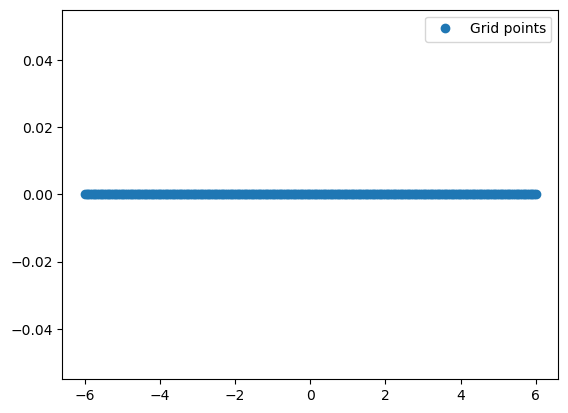

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt

# Define x grid and step size
x = np.linspace(a,b,N)
h = x[1]-x[0]

print(f"Discretized grid with {N} sites and step size {h:.4f}")
plt.plot(x,np.zeros(x.shape),'o', label="Grid points")
plt.legend(loc='upper right');

In [4]:
print(f"The extremal points will not be considered. That is why we have a {N-2}x{N-2} Hamiltonian but {N} points.")

The extremal points will not be considered. That is why we have a 256x256 Hamiltonian but 258 points.


### Potential term and Kinetic term

We use a quadratic potential:
$$
V(x) = \frac{1}{2} x^2
$$

We use finite differences to compute the kinetic term:
$$
T = \frac{1}{2} \frac{\partial^2 \cdot}{\partial x^2} \rightarrow \frac{1}{2} \Big( \frac{\psi(x+1) - 2\psi(x) + \psi(x-1)}{h^2} \Big)
$$

In [5]:
# Define potential energy function. Change this to change the potential.
def Vpot(x):
    return (1/2)*x**2


# Create Kinetic Energy Matrix
T = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            T[i,j]= -2
        elif np.abs(i-j)==1:
            T[i,j]=1
        else:
            T[i,j]=0

# Create Potential Energy Matrix
V = np.zeros((N-2)**2).reshape(N-2,N-2)
for i in range(N-2):
    for j in range(N-2):
        if i==j:
            V[i,j]= Vpot(x[i+1])
        else:
            V[i,j]=0
            
# Create Hamiltonian: a big matrix 😂
H = -T/(2*h**2) + V

#### This is an alternative way without for loops, but using indices only

In [6]:
Tp = np.zeros((N-2,N-2))  # create a kinetic matrix full of zeros 
T_id = np.diag_indices(Tp.shape[0])  # select the indices on the diagonal
T_idp = (T_id[0][:-1],(T_id[1][:-1]+1))  # select the indices above the diagonal y-x=1
T_idm = (T_id[0][:-1]+1,T_id[1][:-1])  # select the indices below the diagonal x-y=1
# fill the 3 "diagonals" with entries for the discretized derivative
Tp[T_id] = -2.0
Tp[T_idp] = Tp[T_idm] = 1.0
# check it is the same as the matrix created with for loops
assert(np.allclose(T,Tp))

In [7]:
Tp.shape

(256, 256)

In [8]:
Vp = np.zeros((N-2,N-2))
V_id = np.diag_indices(Vp.shape[0])
Vp[V_id] = Vpot(x[1:-1])
assert(np.allclose(V,Vp))

In [9]:
Vp.shape

(256, 256)

In [10]:
# this has 2 more sites
x.shape

(258,)

In [11]:
# Create Hamiltonian: a big matrix 😂
Hp = -Tp/(2*h**2) + Vp
assert(np.allclose(H,Hp))

### Plot the Hamiltonian

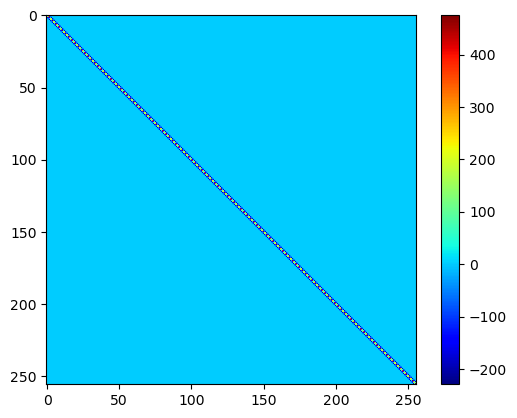

In [12]:
plt.imshow(H, cmap='jet')
plt.colorbar();

## Solve the Schroedinger equation

We solve the Schroedinger equation by finding the eigenvalues and eigenvectors of the Hamiltonian matrix on the 1D grid defined above.

In [13]:
# Find eigenvalues and eigenvectors, then sort them in ascending order
val, vec = np.linalg.eig(H)
z = np.argsort(val)
z = z[0:4]
energies = val[z]
print("Finite Difference Energies for the first 4 states: ", energies)


Finite Difference Energies for the first 4 states:  [0.49993186 1.49965926 2.49911397 3.49829587]


In [14]:
# Compare finite difference calculation to theoretical calculation
nVec = np.linspace(0, len(energies) - 1, len(energies))
En = nVec + 0.5
print("Theoretical Energies: ", En)
percentError = ((En - energies) / (energies)) * 100
print("Percent Error: ", percentError)


Theoretical Energies:  [0.5 1.5 2.5 3.5]
Percent Error:  [0.01362996 0.02272115 0.03545382 0.04871305]


In [15]:
# potential energy
# get the ground state
gs_vec = vec[:,z[0]]
# sandwich the potential energy
gs_vec.T.dot(Vp.dot(gs_vec))

0.24993185483084496

The exact value of the potential energy should be E0/2 = 0.5/2 = 0.25

In [17]:
En[0]/2

0.25

Text(0.5, 1.0, 'normalized wavefunctions for a harmonic oscillator using finite difference method')

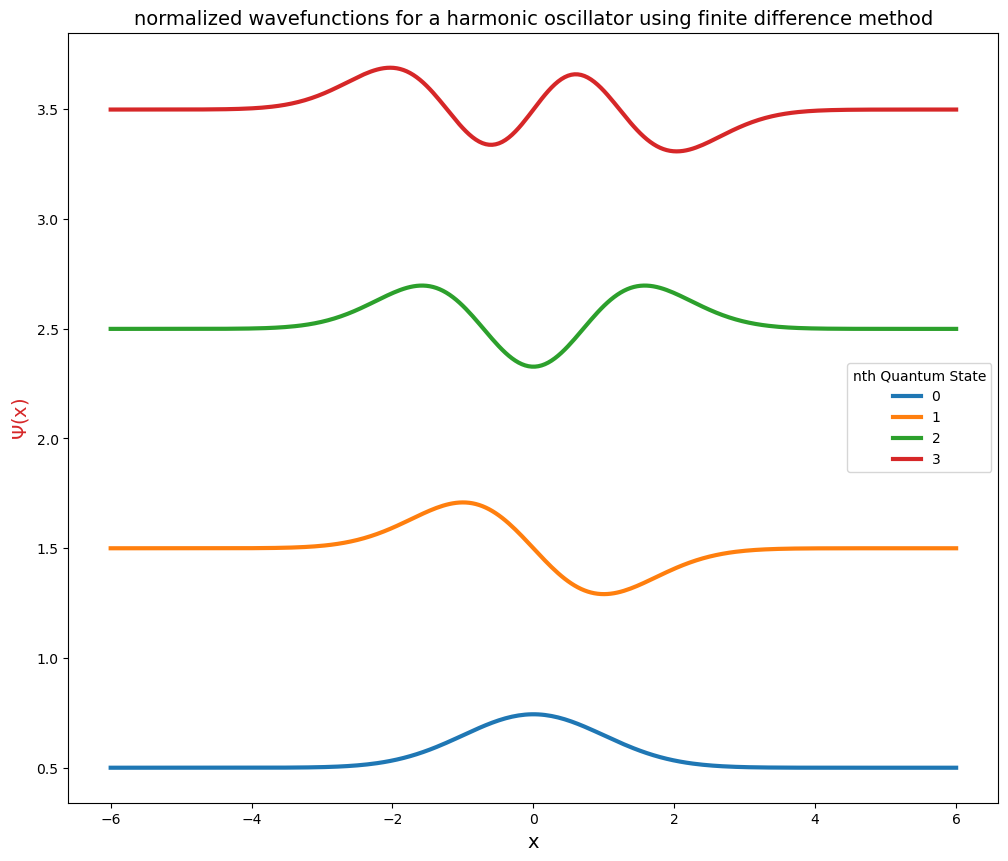

In [18]:
# Plot wavefunctions for first 4 lowest states
plt.figure(figsize=(12,10))
scalingFactor=1.5
for i in range(len(z)):
    y = []
    y = np.append(y,vec[:,z[i]])
    y = np.append(y,0)
    y = np.insert(y,0,0)
    plt.plot(x,scalingFactor*y+energies[i],lw=3, label="{} ".format(i))
plt.xlabel('x', size=14)
plt.ylabel(r'$\Psi$(x)',size=14,color='tab:red')
plt.legend(title="nth Quantum State")
plt.title('normalized wavefunctions for a harmonic oscillator using finite difference method',size=14)

## Truncation Error

We test the truncation error on the ground state energy for different extents of the grid and different spacings (in other words, different number of qubits). 

The bounds are given by $-R$ and $R$ and there is a total of $\Lambda+2$ (N above) points such that the spacing $a$ (h above) is defined as

$$ a = \frac{2R}{\Lambda -1} $$

In [65]:
# function to compute the ground state energy as a function of R and L
def gs_energy(R, L, potential=Vpot):
    # add boundary points
    # Define x grid and step size
    x = np.linspace(-R, R, L)
    h = x[1] - x[0]
    # print(R,L,h)
    # add boundary
    x = np.append(x, x[-1] + h)
    x = np.insert(x, 0, x[0] - h)
    # kinetic
    Tp = np.zeros((L, L))  # create a kinetic matrix full of zeros
    T_id = np.diag_indices(Tp.shape[0])  # select the indices on the diagonal
    T_idp = (
        T_id[0][:-1],
        (T_id[1][:-1] + 1),
    )  # select the indices above the diagonal y-x=1
    T_idm = (
        T_id[0][:-1] + 1,
        T_id[1][:-1],
    )  # select the indices below the diagonal x-y=1
    # fill the 3 "diagonals" with entries for the discretized derivative
    Tp[T_id] = -2.0
    Tp[T_idp] = Tp[T_idm] = 1.0
    # Potential
    Vp = np.zeros((L, L))
    V_id = np.diag_indices(Vp.shape[0])
    Vp[V_id] = potential(x[1:-1])
    # Hamiltonian
    Hp = -Tp / (2 * h**2) + Vp
    # Ground state
    val, vec = np.linalg.eig(Hp)
    z = np.argsort(val)
    # print(val[z[0]])
    delta_energy = np.fabs(val[z[0]] - 0.5)
    # get the ground state
    gs_vec = vec[:, z[0]]
    # sandwich the potential energy
    potential_energy = gs_vec.T.dot(Vp.dot(gs_vec))
    return np.array([h, R, L, delta_energy, potential_energy], dtype=np.float64)


In [66]:
gs_energy(11,1050)

array([2.09723546e-02, 1.10000000e+01, 1.05000000e+03, 1.37453628e-05,
       2.49986254e-01])

Run for different values of R and L

In [102]:
from tqdm.notebook import tqdm

df = list()
# for r in tqdm([0.5,1.,1.5,2.,2.5,3.,3.5,4.,5.,7.,9.,11.], desc='R'):
#   for l in tqdm([50,150,250,350,450,550,650,850,1050], desc='L'):
for r in tqdm([4.,5.,7.,9.,11.], desc='R'):
  for l in tqdm([450,550,650,850,1050], desc='L'):
    df.append(gs_energy(r,l))
df = np.asarray(df)

R:   0%|          | 0/5 [00:00<?, ?it/s]

L:   0%|          | 0/5 [00:00<?, ?it/s]

L:   0%|          | 0/5 [00:00<?, ?it/s]

L:   0%|          | 0/5 [00:00<?, ?it/s]

L:   0%|          | 0/5 [00:00<?, ?it/s]

L:   0%|          | 0/5 [00:00<?, ?it/s]

In [103]:
import pandas as pd

df = pd.DataFrame(df, columns=["A","R","L","D","P"], dtype=np.float64)

In [104]:
df.head()

,A,R,L,D,P
0,0.017817,4.0,450.0,0.000009,0.249987
1,0.014572,4.0,550.0,0.000006,0.249990
2,0.012327,4.0,650.0,0.000004,0.249992
3,0.009423,4.0,850.0,0.000002,0.249994
4,0.007626,4.0,1050.0,0.000001,0.249995


Plot the data

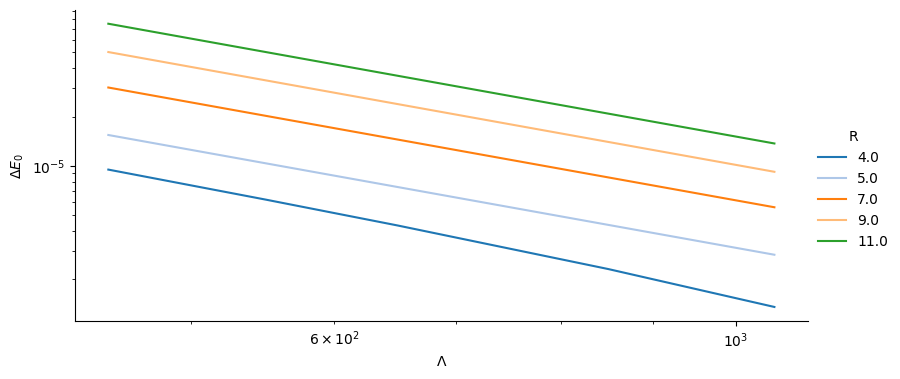

In [105]:
import seaborn as sns 

g = sns.relplot(data=df, x="L", y="D", hue="R", palette='tab20', kind='line', height=4, aspect=2)
g.set_axis_labels(r"$\Lambda$", r"$\Delta E_0$")
g.set(yscale='log', xscale='log')

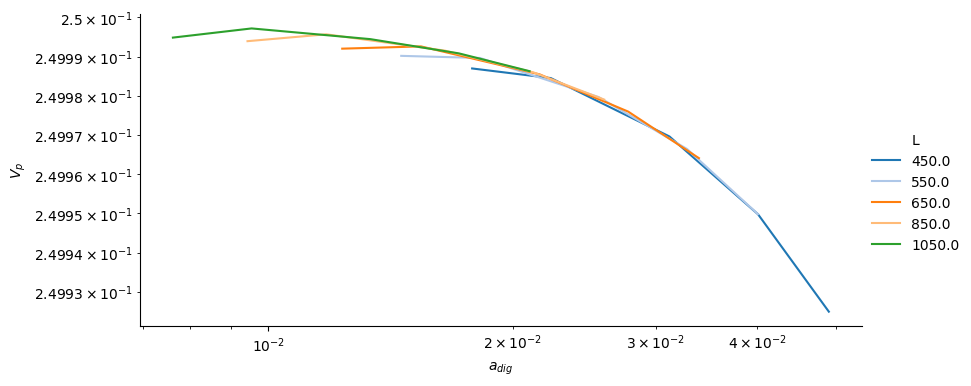

In [106]:
g = sns.relplot(data=df, x="A", y="P", hue="L", palette='tab20', kind='line', height=4, aspect=2)
g.set_axis_labels(r"$a_{dig}$", r"$V_p$")
g.set(yscale='log', xscale='log')

Now we fix $R = 1000 a$ and that means using $\Lambda = 1 + 2 \cdot 1000$

In [61]:
a_dig = 0.7


def ir_cutoff(a_dig):
    return 1_000 * a_dig


def uv_cutoff(a_dig):
    return int(1 + 2 * ir_cutoff(a_dig) / a_dig)


R = ir_cutoff(a_dig)
L = uv_cutoff(a_dig)
print(f"Choosing a_dig={a_dig} with R={R} and L={L}")


Choosing a_dig=0.7 with R=700.0 and L=2001


Look at a quartic potential

In [62]:
# Define potential energy function. Change this to change the potential.
# M^2 = 1
def Vpot_quartic(x):
    return (1/2)*x**2 + (1/4)*x**4

# M^2 = -1
def Vpot_quartic_neg(x):
    return -(1/2)*x**2 + (1/4)*x**4

In [67]:
gs_energy(R,L,potential=Vpot_quartic)

array([3.00000000e-01, 3.00000000e+02, 2.00100000e+03, 1.15531926e-01,
       2.61755387e-01])

In [68]:
gs_energy(R,L,potential=Vpot_quartic_neg)

array([ 3.00000000e-01,  3.00000000e+02,  2.00100000e+03,  3.55047168e-01,
       -6.36313342e-02])

### Finite temperature

We can do the same at finite temperature $T = 1/\beta $. For the quadratic potential we simply use $\langle V \rangle = \langle E \rangle /2$ where (in our units $\omega ^2 = m = \hbar = 1$)

$$ \langle E \rangle_{\beta} =  \frac{1}{2} \frac{e^{\beta/2} + e^{-\beta/2}}{e^{\beta/2} - e^{-\beta/2}}$$

The second part of the formula can be written with the hyperbolic cotangent function (inverse of hyperbolic tangent) $\mathrm{coth}(\beta/2)$

In [20]:
#  T = 0.1
T = 0.1
beta = 1.0/T
print(f"Temperature = {T} \n (beta={beta})")

Temperature = 0.1 
 (beta=10.0)


In [28]:
# Example: correction to the 0.5 ground state energy of the harmonic oscillator at zero temperature
np.fabs(0.5 - 0.5*1./np.tanh(beta/2))

4.540199100966369e-05

In [55]:
def harmonic_energy(beta):
    return 0.5*1./np.tanh(beta/2)


In general, to compute the expectation value of the potential energy at finite temperature we have to sum over all the states

$$ \langle V \rangle_{\beta} \propto \sum_n e^{-\beta E_n} V_n$$ 

In [73]:
# Example: harmonic oscillator potential energy at finite temperature
v_beta = np.sum([np.exp(-beta*val[i])*(vec[:,i].T.dot(Vp.dot(vec[:,i]))) for i in z])
# normalize using the partition function
z_beta = np.sum(np.exp(-beta*val))
v_beta /= z_beta
print(f"Potential energy at beta={beta} : {v_beta}")

Potential energy at beta=10.0 : 0.24995460538940223


In [58]:
# result "in the continuum": it is slightly higher than 0.25 because of thermal fluctuations
harmonic_energy(beta)/2

0.25002270099550483

In [105]:
# function to compute the average potential energy at finite temperature as a function of R and L
def pot_energy(beta, R, L, potential=Vpot):
    # add boundary points
    # Define x grid and step size
    x = np.linspace(-R, R, L)
    h = x[1] - x[0]
    # print(R,L,h)
    # add boundary
    x = np.append(x, x[-1] + h)
    x = np.insert(x, 0, x[0] - h)
    # kinetic
    Tp = np.zeros((L, L))  # create a kinetic matrix full of zeros
    T_id = np.diag_indices(Tp.shape[0])  # select the indices on the diagonal
    T_idp = (
        T_id[0][:-1],
        (T_id[1][:-1] + 1),
    )  # select the indices above the diagonal y-x=1
    T_idm = (
        T_id[0][:-1] + 1,
        T_id[1][:-1],
    )  # select the indices below the diagonal x-y=1
    # fill the 3 "diagonals" with entries for the discretized derivative
    Tp[T_id] = -2.0
    Tp[T_idp] = Tp[T_idm] = 1.0
    # Potential
    Vp = np.zeros((L, L))
    V_id = np.diag_indices(Vp.shape[0])
    Vp[V_id] = potential(x[1:-1])
    # Hamiltonian
    Hp = -Tp / (2 * h**2) + Vp
    # Spectrum: use eigh because eig will not return all eigenvalues correctly (contains nan)
    val, vec = np.linalg.eigh(Hp)
    ei = np.argsort(val)
    # partition function
    z_beta = np.sum(np.exp(-beta * val))
    # potential energy
    v_beta = np.sum(
        [
            np.exp(-beta * val[i]) * (vec[:, i].T.dot(Vp.dot(vec[:, i]))) / z_beta
            for i in ei[::-1]
        ]
    )
    return np.array([h, R, L, z_beta, v_beta], dtype=np.float64)


In [106]:
pot_energy(1/T, a, N, potential=Vpot)

array([-4.66926070e-02, -6.00000000e+00,  2.58000000e+02,  6.74284680e-03,
        2.49954605e-01])

This results matches with what we found before!

We can compute the average potential energy at various values of the digitization spacing and at various temperatures

In [107]:
a_dig = 0.3
R = ir_cutoff(a_dig)
L = uv_cutoff(a_dig)
T = 0.1
beta = 1/T
print(f"Quadratic potential: {pot_energy(beta, R, L, potential=Vpot)}")
print(f"Quartic msq=1 potential: {pot_energy(beta, R, L, potential=Vpot_quartic)}")
print(f"Quartic msq=-1 potential: {pot_energy(beta, R, L, potential=Vpot_quartic_neg)}")

Quadratic potential: [3.00000000e-01 3.00000000e+02 2.00100000e+03 6.93160989e-03
 2.47188074e-01]
Quartic msq=1 potential: [3.00000000e-01 3.00000000e+02 2.00100000e+03 2.12216560e-03
 2.61755964e-01]
Quartic msq=-1 potential: [ 3.00000000e-01  3.00000000e+02  2.00100000e+03  2.34872608e-01
 -6.35438566e-02]


In [109]:
a_dig = 0.5
R = ir_cutoff(a_dig)
L = uv_cutoff(a_dig)
T = 0.1
beta = 1/T
print(f"Quadratic potential: {pot_energy(beta, R, L, potential=Vpot)}")
print(f"Quartic msq=1 potential: {pot_energy(beta, R, L, potential=Vpot_quartic)}")
print(f"Quartic msq=-1 potential: {pot_energy(beta, R, L, potential=Vpot_quartic_neg)}")

Quadratic potential: [5.00000000e-01 5.00000000e+02 2.00100000e+03 7.29526321e-03
 2.42021144e-01]
Quartic msq=1 potential: [5.00000000e-01 5.00000000e+02 2.00100000e+03 2.33828057e-03
 2.53854224e-01]
Quartic msq=-1 potential: [ 5.00000000e-01  5.00000000e+02  2.00100000e+03  2.44863152e-01
 -6.63300330e-02]


In [108]:
a_dig = 0.7
R = ir_cutoff(a_dig)
L = uv_cutoff(a_dig)
T = 0.1
beta = 1/T
print(f"Quadratic potential: {pot_energy(beta, R, L, potential=Vpot)}")
print(f"Quartic msq=1 potential: {pot_energy(beta, R, L, potential=Vpot_quartic)}")
print(f"Quartic msq=-1 potential: {pot_energy(beta, R, L, potential=Vpot_quartic_neg)}")

Quadratic potential: [7.00000000e-01 7.00000000e+02 2.00100000e+03 7.89448288e-03
 2.33913040e-01]
Quartic msq=1 potential: [7.00000000e-01 7.00000000e+02 2.00100000e+03 2.71496633e-03
 2.41375721e-01]
Quartic msq=-1 potential: [ 7.00000000e-01  7.00000000e+02  2.00100000e+03  2.61434678e-01
 -7.02418178e-02]


## Use QISKIT to solve the problem with quantum algorithms

### Convert the Hamiltonian

Now, we take the Hamiltonian matrix and map it onto a qubit operator. There may be better ways to do this now that Qiskit has added new ways to map Hamiltonians to qubit operators.

In [ ]:
import warnings
import time

from qiskit.opflow import MatrixOp

start_time = time.time()
warnings.filterwarnings("ignore")

qubitOp = MatrixOp(primitive=H)

print("Size of Hamiltonian:", np.shape(H))
print(qubitOp)
end_time = time.time()

runtime = end_time-start_time
print('Program runtime: ',runtime)

Next, we create the variational form.

1.   The plot shows in purple the variational parameters used in the construction of the circuit
2.   The plot shows in blue the entanglement with control gates



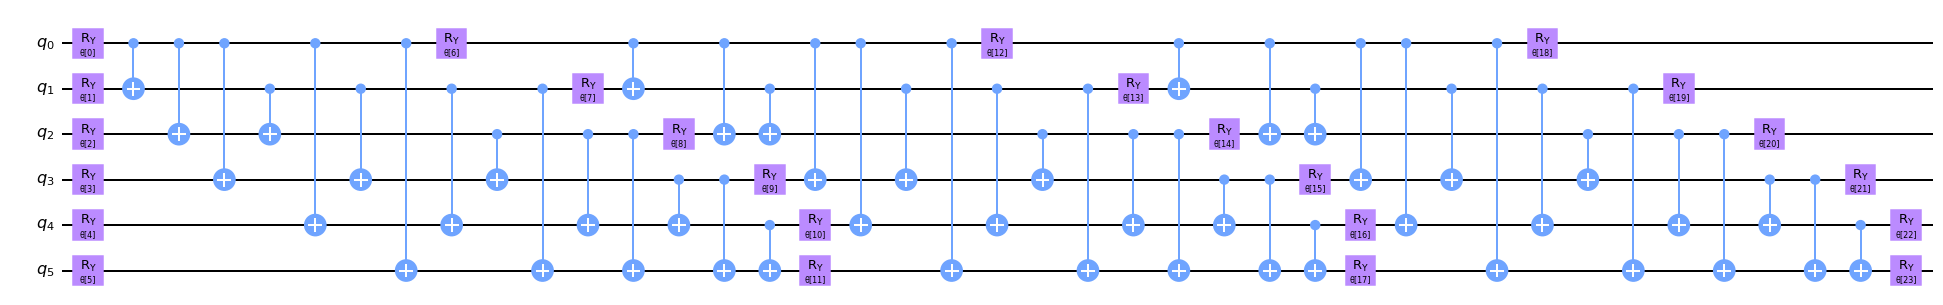

In [ ]:
from qiskit.circuit.library import EfficientSU2

var_form = EfficientSU2(qubitOp.num_qubits, su2_gates=['ry'], entanglement="full", reps=3)
display(var_form.draw(output='mpl',fold=100))

In the next cell, we check the exact minimum eigenvalue of the qubit operator to make sure that our Hamiltonian mapped correctly. We should get the same classical result we have seen in the discretized case before

In [ ]:
from qiskit.algorithms import NumPyEigensolver
# exactly diagonalize the system using numpy routines
solver = NumPyEigensolver(k=4)
exact_solution = solver.compute_eigenvalues(qubitOp)
print("Exact Result of qubit hamiltonian:", np.real(exact_solution.eigenvalues))
print("Exact Result of discrete hamiltonian:", energies[0:4])

Exact Result of qubit hamiltonian: [0.49893263]
Exact Result of discrete hamiltonian: 0.498932627777394


### Run the VQE algorithm

Now, we can run the VQE algorithm.

We can use multiple simulators from the QISKIT ecosystem:

- [A statevector simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.StatevectorSimulator.htm)
- [A Qasm simulator](https://qiskit.org/documentation/stubs/qiskit.providers.aer.QasmSimulator.html)

In [ ]:
from qiskit import Aer  # change this to Aer for C++ compiled code and the option to run on the GPU
from qiskit.algorithms import VQE

#### Statevector simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/02_vqe_convergence.html)

In [ ]:
from qiskit.algorithms.optimizers import SLSQP
from qiskit.utils import algorithm_globals, QuantumInstance

warnings.filterwarnings("ignore")

rngseed = 0
algorithm_globals.random_seed = rngseed

if HAS_GPU:
  # with GPU
  backend = Aer.get_backend("statevector_simulator", method="statevector_gpu")
else:
  # without GPU
  backend = Aer.get_backend("statevector_simulator", max_parallel_threads=1, max_parallel_experiments=0)
q_instance = QuantumInstance(
    backend, seed_transpiler=rngseed, seed_simulator=rngseed
)

optimizer = SLSQP(maxiter=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Run the VQE
vqe = VQE(
    ansatz=var_form,
    optimizer=optimizer,
    quantum_instance=q_instance,
    callback=store_intermediate_result,
)
ret = vqe.compute_minimum_eigenvalue(qubitOp)
vqe_result = np.real(ret.eigenvalue)
print("VQE Result:", vqe_result)

VQE Result: 1.61879053796913
Program runtime: 21.456111431121826 s


Sometimes these results are very bad...we do not get anything close to 0.5

Finally, we plot a convergence plot of the VQE results.

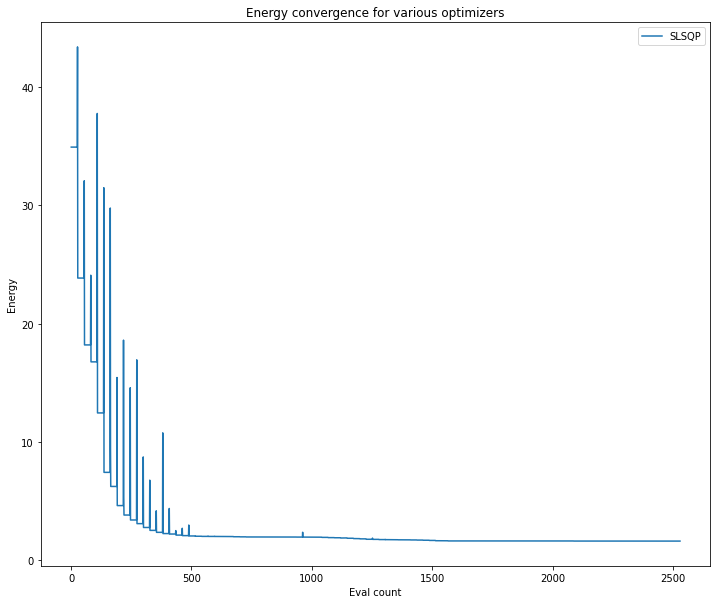

In [ ]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SLSQP")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence')
plt.legend(loc='upper right')

#### QASM simulator

Example from [here](https://qiskit.org/documentation/tutorials/algorithms/03_vqe_simulation_with_noise.html#Performance-without-noise)

In [ ]:
ffrom qiskit.algorithms.optimizers import SPSA
from qiskit.utils import algorithm_globals, QuantumInstance

rngseed = 0
algorithm_globals.random_seed = rngseed

if HAS_GPU:
  backendQasm = Aer.get_backend('qasm_simulator', method="statevector_gpu")
else:
  backendQasm = Aer.get_backend('qasm_simulator', method="statevector")
  
q_instance = QuantumInstance(backend=backendQasm, shots=1024, seed_transpiler=rngseed, seed_simulator=rngseed)
optimizer = SPSA(maxiter=600)

counts = []
values = []
def store_intermediate_result(eval_count, parameters, mean, std):
    counts.append(eval_count)
    values.append(mean)

# Run the VQE
vqe = VQE(
    ansatz=var_form,
    optimizer=optimizer,
    quantum_instance=q_instance,
    callback=store_intermediate_result,
)
ret = vqe.compute_minimum_eigenvalue(qubitOp)
vqe_result = np.real(ret.eigenvalue)
print("VQE Result:", vqe_result)

VQE Result: 2.5247894634219064
Program runtime: 1298.9465007781982 s


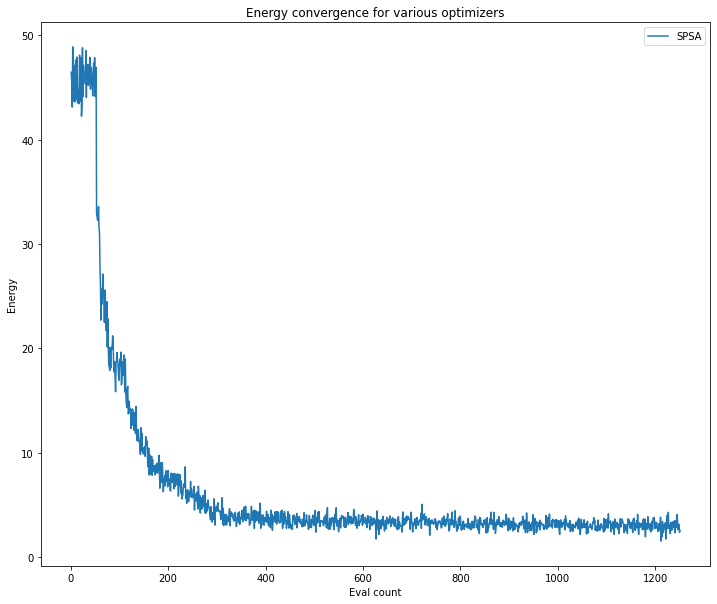

In [ ]:
# Plot convergence plot
plt.figure(figsize=(12,10))
plt.plot(counts, values, label="SPSA")
plt.xlabel('Eval count')
plt.ylabel('Energy')
plt.title('Energy convergence for various optimizers')
plt.legend(loc='upper right')

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

{'qiskit': None,
 'qiskit-aer': '0.7.3',
 'qiskit-aqua': '0.8.1',
 'qiskit-ibmq-provider': '0.11.1',
 'qiskit-ignis': '0.5.1',
 'qiskit-terra': '0.16.3'}